<a href="https://colab.research.google.com/github/AlyaAlshammari/CS702/blob/main/CS702Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENHANCING SOFTWARE SECURITY WITH COLLABORATIVE LLM-BASED AGENTS  

The goal of this project is to develop a more secure LLM-driven agent that automates
code generation, vulnerability detection, and security enhancement. This
comprehensive approach streamlines the coding process while ensuring that generated
outputs meet high-security standards, reducing the need for manual intervention and
improving overall software reliability.

- CGA handles natural language to code conversion.

- VAA integrates Bandit for static security analysis.

- SEA uses GPT-4 to enhance security based on detected issues.

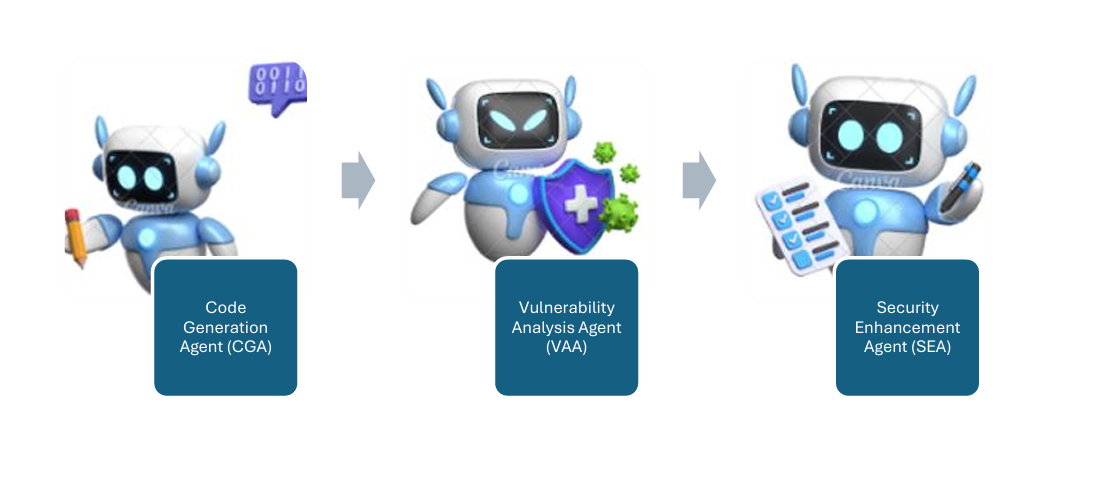

The process begins by providing code generation requirements or task descriptions to
the Code Generation Agent (CGA) , which utilizes ChatGPT-4 or DeepSeek to produce
code snippets. Once the code is generated, it is passed to the Vulnerability Analysis
Agent (VAA) , which identifies potential security flaws through a combination of static and
dynamic security analysis techniques. If vulnerabilities are detected, the Security
Enhancement Agent (SEA), which is fine-tuned on outputs from the VAA, automatically
applies fixes to mitigate the identified security issues. This iterative process continues until no further vulnerabilities are found.

### Setup and Libraries

In [ ]:
!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cud

In [ ]:
!pip install bandit --quiet
!pip install --upgrade openai --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.0/662.0 kB 42.5 MB/s eta 0:00:00


Note : after inastalling libraries , Restart the session  and Rerun all

In [ ]:
import openai
import tempfile
import subprocess
import json
import time
from openai import OpenAI
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datasets import load_dataset

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "write-your-openAI-API-key"


In [ ]:
client = OpenAI()

## The proposed framework of the CGA-VAA-SEA system

### Code Generation Agent (CGA)

Uses GPT-4 to generate code based on a task description.

In [ ]:
import openai

client = openai.OpenAI()

def generate_code(task_description):
    print("[CGA] Generating code...")
    prompt = f"""You are a Python expert.

    Task: {task_description}

    Please write a concise, idiomatic Python snippet that performs this task exactly as described. Prefer short function definitions, common library usage, and match the variable names from the task if applicable.
    Guidelines:
    - Use common, standard Python libraries (e.g., `re`, `os`, `collections`, `itertools`).
    - Keep function definitions short and readable.
    - **Match variable and function names** to those mentioned in the task (if any).
    - **Follow typical Python style** (as seen in CoNaLa or Stack Overflow).
    - Prefer one-liners or short, functional solutions if appropriate.
    - Avoid extra print/debug statements, comments, or explanations.
    - Return only the code snippet — no prose.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2,
        )
        content = response.choices[0].message.content.strip()
    except Exception as e:
        print("[ERROR] Failed to generate code:", e)
        return None

    # Extract code from markdown
    if "```python" in content:
        code = content.split("```python")[1].split("```")[0].strip()
    elif "```" in content:
        code = content.split("```")[1].strip()
    else:
        code = content.strip()

    return code if code else None


### Vulnerability Analysis Agent (VAA)

Analyzes the code using Bandit and returns a list of security issues.Bandit is a static code analysis tool specifically designed to find security vulnerabilities in Python code. It was developed by the OpenStack Security team.



In [ ]:
def analyze_code(code):
    print("[VAA] Analyzing code with Bandit...")
    try:
        with tempfile.NamedTemporaryFile(mode='w+', suffix='.py', delete=False) as f:
            f.write(code)
            f.flush()
            result = subprocess.run(
                ["bandit", f.name, "-r", "-f", "json"],
                capture_output=True,
                text=True
            )

        result_json = json.loads(result.stdout)
        issues = result_json.get("results", [])
        return issues
    except Exception as e:
        print(f"[ERROR] Failed to analyze code: {e}")
        return []


### Security Enhancement Agent (SEA)

Uses GPT-4 to fix the code based on vulnerabilities found.


In [ ]:
def enhance_security(code, issues_summary):
    print("[SEA] Enhancing code to fix vulnerabilities...")

    prompt = f"""
You are a security-focused Python expert.

The following code has the listed security vulnerabilities:
{issues_summary}

Please return only the corrected code, with:
- Minimal changes necessary to fix the vulnerabilities
- No changes to variable names or overall structure
- No added comments, docstrings, or explanations
- No markdown formatting (like triple backticks)
- Maintain exact original functionality

Correct this code:
{code}
"""

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2,
        )
        updated_code = response.choices[0].message.content.strip()
        updated_code = updated_code.removeprefix("```python").removesuffix("```").strip()
        return updated_code
    except Exception as e:
        print(f"[ERROR] Failed to enhance code: {e}")
        return None


### Control Loop for Iterative Refinement

A control loop that iterates through code generation, analysis, and fixing until no vulnerabilities are found or max iterations reached.

In [ ]:
def summarize_issues(issues):
    summary_lines = []
    for issue in issues:
        line = f"[{issue.get('severity', 'UNKNOWN')}] {issue.get('test_name', 'UnknownCheck')}: {issue.get('issue_text', '').strip()} (line {issue.get('line_number', '?')})"
        summary_lines.append(line)
    return "\n".join(summary_lines)

In [ ]:
def refine_code_until_secure(task, max_iterations=5):
    code = generate_code(task)
    if not code:
        print("[ERROR] No code was generated.")
        return None, 0, 0, 0  # return final_code, iterations, issues_before, issues_after

    for i in range(max_iterations):
        print(f"\n[Loop Iteration {i+1}]")

        issues = analyze_code(code)
        issues_summary = summarize_issues(issues)
        issue_count = len(issues)

        if i == 0:
            issues_before = issue_count  # Capture first round issue count

        print(f"[INFO] Number of issues before fix: {issue_count}")
        if issue_count == 0:
            print("[VAA] No security issues found.")
            return code, i + 1, issues_before, 0

        improved_code = enhance_security(code, issues_summary)
        if not improved_code or improved_code == code:
            print("[INFO] No change in code after enhancement. Stopping.")
            return code, i + 1, issues_before, issue_count

        code = improved_code

    # Final analysis after last iteration
    final_issues = analyze_code(code)
    return code, max_iterations, issues_before, len(final_issues)


### Test

In [ ]:
task = "Write a Python script that accepts a filename from the user and prints its contents."
final_code, iterations, issues_before, issues_after = refine_code_until_secure(task)
print("\n=== Final Secured Code ===")
print(final_code)
print(f"\nIterations: {iterations}")
print(f"Issues Before: {issues_before}")
print(f"Issues After: {issues_after}")

[CGA] Generating code...

[Loop Iteration 1]
[VAA] Analyzing code with Bandit...
[INFO] Number of issues before fix: 0
[VAA] No security issues found.

=== Final Secured Code ===
def print_file_contents():
    filename = input("Please enter a filename: ")
    try:
        with open(filename, 'r') as file:
            print(file.read())
    except FileNotFoundError:
        print("File not found. Please check the filename and try again.")

print_file_contents()

Iterations: 1
Issues Before: 0
Issues After: 0


## Evaluate the proposed framework on CoNaLa

In [ ]:
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction



Load the CoNaLa (the Code/Natural Language) dataset, it includes 2,379 training examples and 500 test examples.

In [ ]:
dataset = load_dataset("neulab/conala")
test_data = dataset['test']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

conala.py:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

The repository for neulab/conala contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/neulab/conala.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


conala-paired-train.json:   0%|          | 0.00/518k [00:00<?, ?B/s]

conala-paired-test.json:   0%|          | 0.00/109k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Display a sample from the data


Each entry in the dataset contains:

  - question_id: Identifier of the Stack Overflow question

  - intent: Original natural language description of the task

  - rewritten_intent: Refined intent incorporating specific variable names or function arguments

  - snippet: Python code snippet that fulfills the described intent
  GitHub




In [ ]:
print(test_data[0])

{'question_id': 15080500, 'intent': 'How can I send a signal from a python program?', 'rewritten_intent': 'send a signal `signal.SIGUSR1` to the current process', 'snippet': 'os.kill(os.getpid(), signal.SIGUSR1)'}


In [ ]:
results = []

for idx, example in enumerate(test_data):
    task           = example["intent"]
    reference_code = example.get("snippet", "") #ground truth
    print(f"\n=== Test Example {idx+1}/{len(test_data)}: {task!r} ===")

    final_code, iterations, issues_before, issues_after = refine_code_until_secure(task)


    if final_code and reference_code:
        bleu = sentence_bleu(
            [reference_code.split()],
            final_code.split(),
            smoothing_function=SmoothingFunction().method1
        )
    else:
        bleu = 0.0

    # Record Results
    results.append({
        "intent":         task,
        "reference_code": reference_code,
        "final_code":     final_code,
        "issues_before":  issues_before,
        "issues_after":   issues_after,
        "iterations":     iterations,
        "bleu":           bleu
    })

#Save results
with open("conala_test_secure_results.json", "w") as f:
    json.dump(results, f, indent=2)

#Compute evaluation metrics
n           = len(results)
completed   = sum(1 for r in results if r["final_code"] is not None)
avg_before  = sum(r["issues_before"] for r in results) / n
avg_after   = sum(r["issues_after"]  for r in results) / n
avg_iters   = sum(r["iterations"]    for r in results) / n
failures    = sum(1 for r in results if r["issues_after"] > 0)
avg_bleu = sum(r["bleu"] for r in results) / n



print(f" # Tasks completed:           {completed}/{n}")
print(f" Avg issues before SEA:        {avg_before:.2f}")
print(f" Avg issues after SEA:         {avg_after:.2f}")
print(f" Avg iterations needed:    {avg_iters:.2f}")
print(f" Fixing failed cases:       {failures}/{n}")
print(f" Avg BLEU score:              {avg_bleu:.4f}")




=== Test Example 1/500: 'How can I send a signal from a python program?' ===
[CGA] Generating code...

[Loop Iteration 1]
[VAA] Analyzing code with Bandit...
[INFO] Number of issues before fix: 0
[VAA] No security issues found.

=== Test Example 2/500: 'Decode Hex String in Python 3' ===
[CGA] Generating code...

[Loop Iteration 1]
[VAA] Analyzing code with Bandit...
[INFO] Number of issues before fix: 0
[VAA] No security issues found.

=== Test Example 3/500: 'check if all elements in a list are identical' ===
[CGA] Generating code...

[Loop Iteration 1]
[VAA] Analyzing code with Bandit...
[INFO] Number of issues before fix: 0
[VAA] No security issues found.

=== Test Example 4/500: 'Format string dynamically' ===
[CGA] Generating code...

[Loop Iteration 1]
[VAA] Analyzing code with Bandit...
[INFO] Number of issues before fix: 0
[VAA] No security issues found.

=== Test Example 5/500: 'How to convert a string from CP-1251 to UTF-8?' ===
[CGA] Generating code...

[Loop Iteration 1]


## Evaluate the proposed framework on injected security vulnerabilities

Add random security vulnerabilities to 100 test samples from the CoNaLa dataset

In [ ]:
# Using Predefined Bandit-detectable security patterns
SECURITY_PATTERNS = [
    "eval(input('Enter command: '))",             # B307
    "pickle.loads(user_input)",                   # B301
    "subprocess.Popen(user_input, shell=True)",   # B602/B603
    "assert user.is_admin",                       # B101
    "yaml.load(data)",                            # B506
]

In [ ]:
import random
def inject_security_issues(code, num_issues=1):
    lines = code.split('\n')
    for _ in range(num_issues):
        vuln_code = random.choice(SECURITY_PATTERNS)
        insert_line = random.randint(0, len(lines))
        lines.insert(insert_line, vuln_code)
    return '\n'.join(lines)

In [ ]:
def refine_code(task, max_iterations=5):
    code = generate_code(task)
    if not code:
        print("[ERROR] No code was generated.")
        return None, 0, 0, 0

    # Inject security issues
    code = inject_security_issues(code, num_issues=2)

    for i in range(max_iterations):
        print(f"\n[Loop Iteration {i+1}]")
        issues = analyze_code(code)
        issues_summary = summarize_issues(issues)
        issue_count = len(issues)

        if i == 0:
            issues_before = issue_count

        print(f"[INFO] Number of issues before fix: {issue_count}")
        if issue_count == 0:
            print("[VAA] No security issues found.")
            return code, i + 1, issues_before, 0

        improved_code = enhance_security(code, issues_summary)
        if not improved_code or improved_code == code:
            print("[INFO] No change in code after enhancement. Stopping.")
            return code, i + 1, issues_before, issue_count

        code = improved_code

    final_issues = analyze_code(code)
    return code, max_iterations, issues_before, len(final_issues)

In [ ]:
dataset = load_dataset("neulab/conala")
test_data = dataset["test"].select(range(100))

results = []

for idx, example in enumerate(test_data):
    task = example["intent"]
    reference_code = example.get("snippet", "")
    print(f"\n=== Test Example {idx+1}/100 ===\nTask: {task}")

    final_code, iterations, issues_before, issues_after = refine_code(task)

    if final_code and reference_code:
        bleu = sentence_bleu(
            [reference_code.split()],
            final_code.split(),
            smoothing_function=SmoothingFunction().method1
        )
    else:
        bleu = 0.0

    results.append({
        "intent":         task,
        "reference_code": reference_code,
        "final_code":     final_code,
        "issues_before":  issues_before,
        "issues_after":   issues_after,
        "iterations":     iterations,
        "bleu":           bleu
    })

with open("conala_test_secure_with_injection.json", "w") as f:
    json.dump(results, f, indent=2)

# Summary
n = len(results)
completed = sum(1 for r in results if r["final_code"] is not None)
avg_before = sum(r["issues_before"] for r in results) / n
avg_after = sum(r["issues_after"] for r in results) / n
avg_iters = sum(r["iterations"] for r in results) / n
failures = sum(1 for r in results if r["issues_after"] > 0)
avg_bleu = sum(r["bleu"] for r in results) / n

print(f"\n===== Evaluation Results (100 samples) =====")
print(f"Tasks completed:         {completed}/{n}")
print(f"Avg issues before SEA:   {avg_before:.2f}")
print(f"Avg issues after SEA:    {avg_after:.2f}")
print(f"Avg iterations used:     {avg_iters:.2f}")
print(f"Unresolved cases:        {failures}/{n}")
print(f"Avg BLEU score:          {avg_bleu:.4f}")



=== Test Example 1/100 ===
Task: How can I send a signal from a python program?
[CGA] Generating code...

[Loop Iteration 1]
[VAA] Analyzing code with Bandit...
[INFO] Number of issues before fix: 2
[SEA] Enhancing code to fix vulnerabilities...

[Loop Iteration 2]
[VAA] Analyzing code with Bandit...
[INFO] Number of issues before fix: 0
[VAA] No security issues found.

=== Test Example 2/100 ===
Task: Decode Hex String in Python 3
[CGA] Generating code...

[Loop Iteration 1]
[VAA] Analyzing code with Bandit...
[INFO] Number of issues before fix: 0
[VAA] No security issues found.

=== Test Example 3/100 ===
Task: check if all elements in a list are identical
[CGA] Generating code...

[Loop Iteration 1]
[VAA] Analyzing code with Bandit...
[INFO] Number of issues before fix: 1
[SEA] Enhancing code to fix vulnerabilities...

[Loop Iteration 2]
[VAA] Analyzing code with Bandit...
[INFO] Number of issues before fix: 2
[SEA] Enhancing code to fix vulnerabilities...

[Loop Iteration 3]
[VAA]